#**Challenge Proposition: Churn Prediction for a Telecom Company**

###Proposed by:

- **Maroua Maachou**
- **Guillaume Balezo**
- **Samia Mikou**
- **Benjamin Vignal**
- **Mohamed Ali Jebali**


## **Summary:**

- **I.** Motivation: Data Science in business cases
- **II.** Description of the Dataset
- **III.** Exploratory Data Analysis
- **IV.** Models fitting, Benchmark and Optimization
- **V.** Data Augmentation
- **VI.** Metric Choice
-**VII.** To go Further: Model Explanation

## **I. Motivation: Data Science in business cases**

Customer churn is one of the most important metrics for a growing business to evaluate. While it's not the happiest measure, it's a value that can give your company the hard truth about its customer retention. It usually depends on multiple factors/features that could be categorical, numerical or even in the most hard cases can take several time series signal as features.

Business Analysts consider that the usual rate of client churn in companies differ from one sector to another. In France, The churn rate was about **$20$%** for Telecom companies in 2004 while it has been approximately about **$5$ ~  $7$%** in the bank sector. So this is clearly not a problem of a uniformly or equally distributed data set. The motivation of the solution should consider that this study case is more about **Unbalanced binary classification**, which is very challenging for data scientists.

The main objective would not only be to have a model which gives a good accuracy, but we will be more interested in detecting and predicting the churned clients (label=$1$). In Part $V$ So the metric used for assessing the quality of a model will be the $AUC-ROC$.

##**II. Description of the Dataset**

We have downloaded an available dataset from "bigml.com" (Referenced in the end). It is a csv file "Churn_DataCamp.csv" containing more than **11000** samples of customer informations. Every observations has $19$ categorical and numerical features that are described below:  

- **Categorical Features**:
  - **CUSTOMER_ID** :A technical unique identifier
  - **COLLEGE** : whether the customer is college educated or not. ('zero' and 'one')
  - **REPORTED_SATISFACTION**: Reported level of satisfaction. 5 Levels of satisfaction possible.
  - **REPORTED_USAGE_LEVEL**: Self reported usage level: 5 levels available.
  - **CONSIDERING_CHANGE_OF_PLAN**: Self reported consideration whether to change operator. 5 answers available.
  - **CHURNED**: Whether the customer stayed or left ('STAY' or 'LEAVE').

- **Numerical Features**
  - **DATA** : Total consumption of data per month.
  - **INCOME**: Annual income (salary) of the client
  - **OVERCHARGE**: Average overcharge per year
  - **LEFTOVER**: Average number of lefover minutes per month
  - **HOUSE**: Estimated value of dwelling (from census tract)
  - **LESSTHAN600k**: Boolean value that indicates whether the House value is smaller or higher than 600k. (True or False)
  - **CHILD**: Number of children
  - **JOB_CLASS**: Self reported type of job
  - **REVENUE**: Annual phone bill (excluding Overcharge)
  - **HANDSET_PRICE**: Cost of phone
  - **OVER_15MINS_CALLS_PER_MONTH**: Average number of long calls (>15 mins) per month
  - **TIME_CLIENT**: Tenure in years
  - **AVERAGE_CALL_DURATION**: Average duration of a call


##**III. Exploratory Data Analysis**



### Load the Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold,cross_validate, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC



from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#Ignore deprecation warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
df_train = pd.read_csv('churn_train.csv')
df_train = df_train.drop(columns=['Unnamed: 0'])
df_test = pd.read_csv('churn_test.csv')
df_test = df_test.drop(columns=['Unnamed: 0'])

df = pd.concat((df_train, df_test), axis=0)
df = df.drop(columns=['CUSTOMER_ID'])


In [ ]:
df['COLLEGE'] = np.where((df.COLLEGE == 'one'),1,df.COLLEGE)  
df['COLLEGE'] = np.where((df.COLLEGE == 'zero'),0,df.COLLEGE) 

df['LESSTHAN600k'] = np.where((df.LESSTHAN600k == True),1,df.LESSTHAN600k)
df['LESSTHAN600k'] = np.where((df.LESSTHAN600k == False),0,df.LESSTHAN600k) 

df.head(5)



,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,LESSTHAN600k,CHILD,JOB_CLASS,REVENUE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURNED
0,1,285.714286,55575.0,152,34,830114.0,0,1,3,180.0,356,15,2.4,1,unsat,very_high,considering,0
1,1,630.000000,61718.5,0,7,275633.0,1,0,4,118.0,785,19,3.1,6,very_unsat,very_high,considering,0
2,1,90.000000,65655.5,0,16,903912.0,0,1,4,164.0,695,0,1.3,1,very_unsat,high,considering,0
3,1,424.929178,57122.0,173,8,730144.0,0,2,2,140.0,335,26,5.0,4,very_unsat,little,considering,0
4,1,389.610390,64401.0,54,0,692355.0,0,2,1,110.0,691,1,2.0,10,very_unsat,very_little,considering,0


In [ ]:
if df.isnull().sum().sum()==0:
  print('Our data is clean!')
else:
  print('verify your dataset: There are some missing values!') 


verify your dataset: There are some missing values!


We need to handle the missing values: Should we drop the lines containing the missing values? Or Will we use the same strategy for filling the missing values in the categorical and numerical features?**

In [ ]:
df = df.replace([np.inf, -np.inf], np.nan)    #Here we change infinite values to NaN
df=df.fillna(-999)

### Label distribution


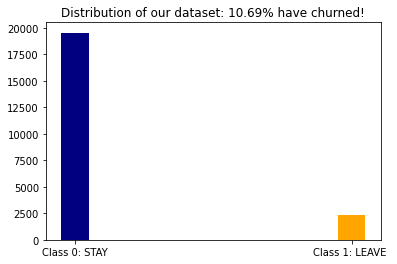

In [ ]:
labels = df['CHURNED'].to_numpy()
nb_stay = (labels == 0).sum()
nb_leave = (labels == 1).sum()
data = {'Class 0: STAY': nb_stay, 'Class 1: LEAVE ': nb_leave}
names = list(data.keys())
values = list(data.values())

plt.bar(names, values, 0.1, color=['navy', 'orange'])
percent_leave = round(nb_leave / (len(df)) * 100, 2)
plt.title('Distribution of our dataset: {}% have churned!'.format(percent_leave))
plt.show()

The previous figure shows that our binary labels are highly imbalanced. 

Approximatively 10,7% of the customers in our dataset have churned.


### Numerical features

In [ ]:
df_numerical = df.select_dtypes(include=np.number)
df_numerical = df_numerical.drop(columns=['CHURNED'])
print('There are {} numerical features'.format(df_numerical.shape[1]))

There are 14 numerical features


There are 14 numerical features:
- 9 features with integers values
- 5 features with floating values

In [ ]:
df_numerical.describe().round()

,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,LESSTHAN600k,CHILD,JOB_CLASS,REVENUE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION
count,21862.0,21862.0,21862.0,21862.0,21862.0,21862.0,21862.0,21862.0,21862.0,21862.0,21862.0,21862.0,21862.0,21862.0
mean,0.0,491.0,45765.0,71.0,23.0,504471.0,1.0,2.0,3.0,155.0,375.0,7.0,3.0,6.0
std,1.0,446.0,21497.0,81.0,26.0,284475.0,0.0,1.0,1.0,47.0,207.0,8.0,2.0,4.0
min,0.0,0.0,10032.0,-2.0,0.0,-999.0,0.0,0.0,1.0,53.0,130.0,0.0,0.0,1.0
25%,0.0,174.0,28132.0,0.0,0.0,253280.0,0.0,1.0,1.0,121.0,214.0,1.0,2.0,2.0
50%,0.0,357.0,43093.0,51.0,14.0,491201.0,1.0,2.0,3.0,149.0,314.0,3.0,3.0,5.0
75%,1.0,674.0,62574.0,118.0,36.0,753262.0,1.0,3.0,4.0,181.0,478.0,10.0,4.0,9.0
max,1.0,4410.0,104086.0,295.0,89.0,999996.0,1.0,7.0,4.0,438.0,899.0,29.0,19.0,15.0


In [ ]:
# plot function

def num_plot(df, feature):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))
    plt.title("KDE for {}".format(feature))
    sns.kdeplot(df[df['CHURNED'] == 0][feature].dropna(), color= 'navy', label= 'Churn: No', ax=ax1)
    sns.kdeplot(df[df['CHURNED'] == 1][feature].dropna(), color= 'orange', label= 'Churn: Yes', ax=ax1)
    ax1.legend()
    sns.boxplot(x="CHURNED", y=feature, data=df, showfliers = False, ax=ax2)


We will plot here the distribution of some important numerical features conditionnaly to the two classes.

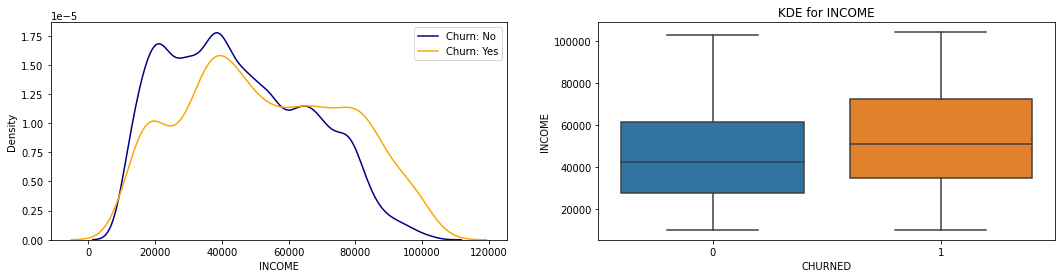

In [ ]:
num_plot(df, 'INCOME')

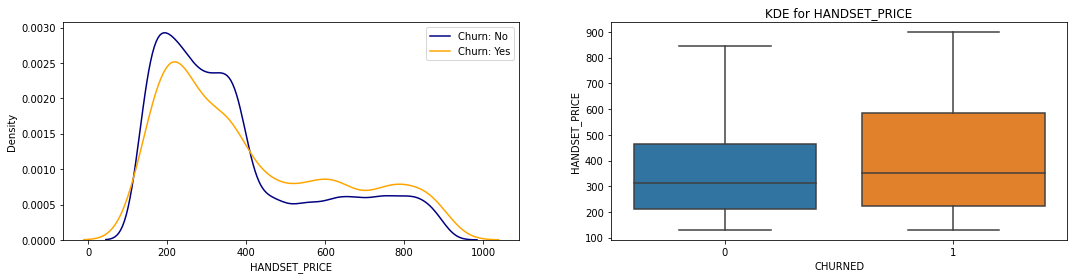

In [ ]:
num_plot(df, 'HANDSET_PRICE')

The clients who have higher incomes seems to be more likely to churn. As with a higher income a user is more likely to have an expensive phone, we can make a similar observation on the feature HANDSET_PRICE.

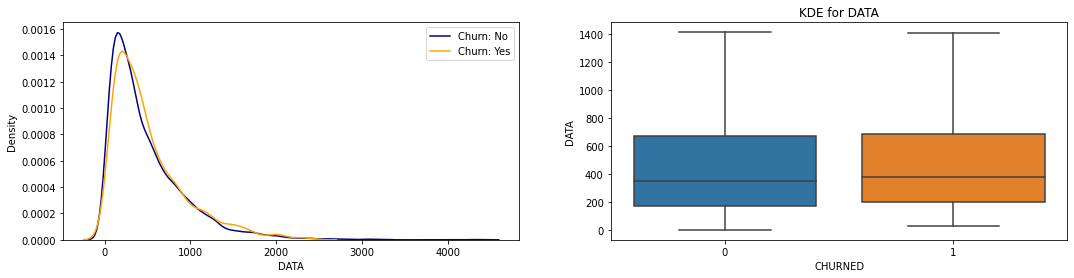

In [ ]:
num_plot(df, 'DATA')

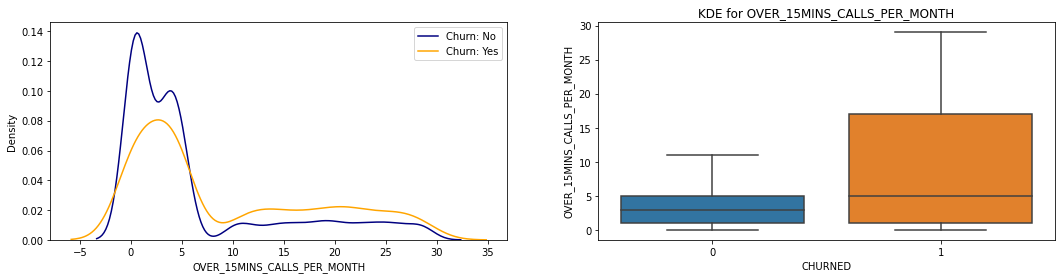

In [ ]:
num_plot(df, 'OVER_15MINS_CALLS_PER_MONTH')

The total consumption of data of the users who leave the operator seems to be slightly higher (mean: 488 vs 516). In the same way, these users have a higher average number of long calls.

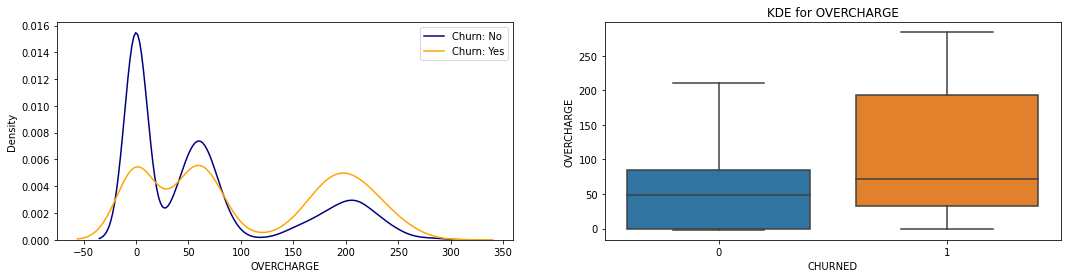

In [ ]:
num_plot(df, 'OVERCHARGE')

The clients with higher overcharges are more likely to churn.

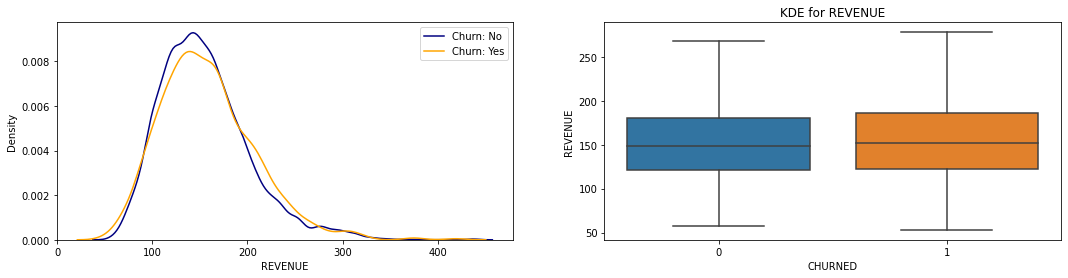

In [ ]:
num_plot(df, 'REVENUE')

The two conditional distributions of the annual phone bill are very similars.

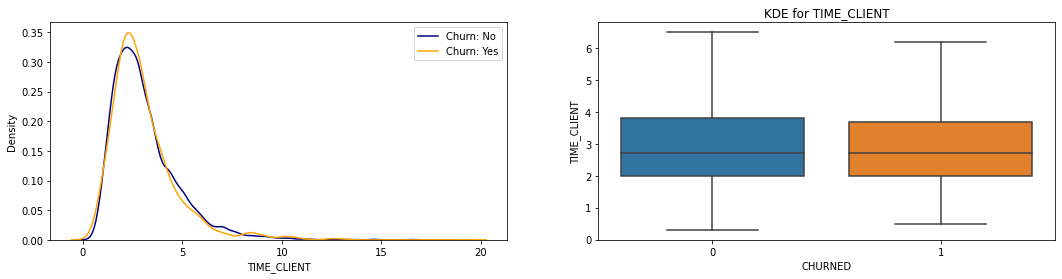

In [ ]:
num_plot(df, 'TIME_CLIENT')

Recent clients seems to be more likely to churn (means in years: 3.06 vs 3.1)

### Categorical features

In [ ]:
columns_num = df.select_dtypes(include=np.number).columns
df_categorical = df.drop(columns=columns_num)
print('There are {} categorical features'.format(df_categorical.shape[1]))

There are 3 categorical features


There are 3 features:
- 3 features with 5 values

In [ ]:
df_categorical.describe()

,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN
count,21862,21862,21862
unique,5,5,5
top,very_unsat,little,considering
freq,9093,8718,8802


In [ ]:
# plot function

def cat_plot(df, feature, orient='v', axis_name="percentage of customers per classes"):
    ratios = pd.DataFrame()
    g = df.groupby(feature)["CHURNED"].value_counts().to_frame()
    g = g.rename({"CHURNED": axis_name}, axis=1).reset_index()
    nb_churned = (df['CHURNED'] == 1).sum()
    nb_non_churned = (df['CHURNED'] == 0).sum()
    g[axis_name] = g[axis_name].where(g['CHURNED']==1,
                                      g[axis_name] / nb_non_churned,
                                      axis=0)
    g[axis_name] = g[axis_name].where(g['CHURNED']==0,
                                      g[axis_name] / nb_churned,
                                      axis=0)
    if orient == 'v':
        ax = sns.barplot(x=feature, y= axis_name, hue='CHURNED', data=g, orient=orient)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
    else:
        ax = sns.barplot(x= axis_name, y=feature, hue='CHURNED', data=g, orient=orient)
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    ax.plot()

We will plot here the distribution of some important categorical features conditionnaly to the two classes.

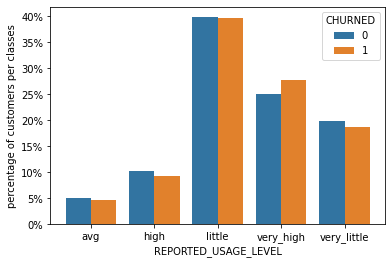

In [ ]:
cat_plot(df, "REPORTED_USAGE_LEVEL")

On this plot we can see that the customers who have left the operator have globally a high usage level. It is in accordance with the distribution of the numerical features DATA and OVER_15MINS_CALLS_PER_MONTH.

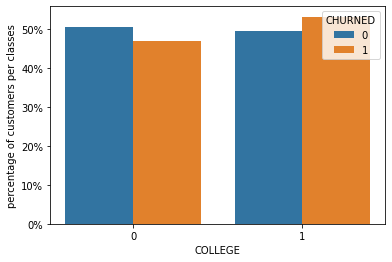

In [ ]:
cat_plot(df, "COLLEGE")

The customers who leave the operator are mostly educated, unlike those who belong to the other category.

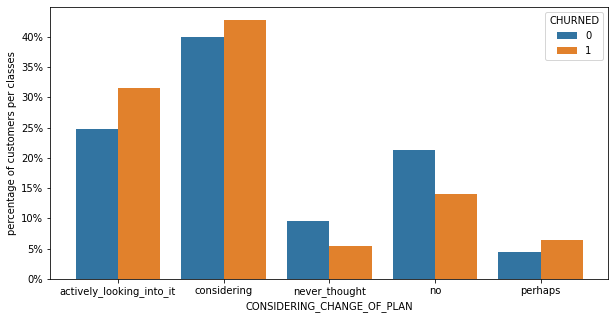

In [ ]:
plt.figure(figsize=(10, 5))
cat_plot(df, "CONSIDERING_CHANGE_OF_PLAN")

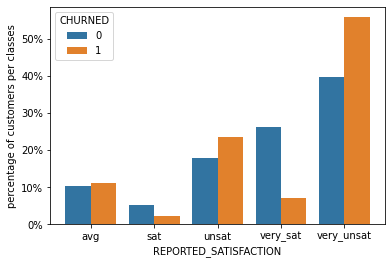

In [ ]:
cat_plot(df, "REPORTED_SATISFACTION")

Obviously, those who leave are globally unsatisfied and are concidering to change operator.

### Correlation between features (Pearson)

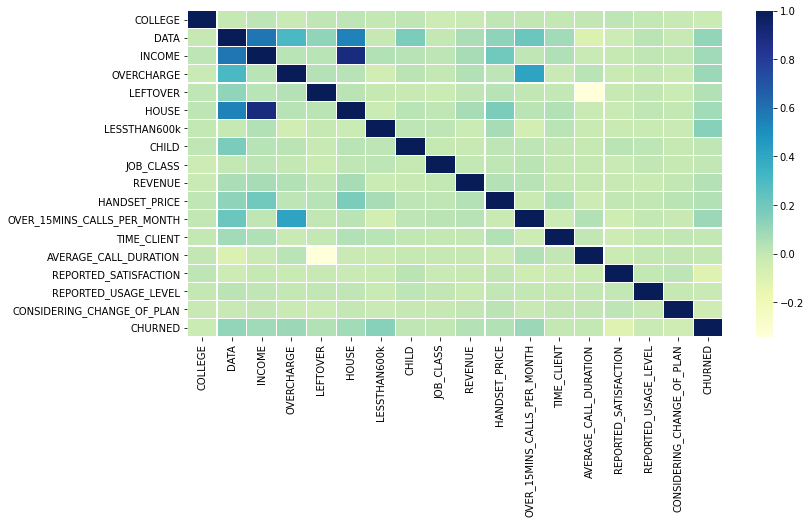

In [ ]:
plt.figure(figsize=(12, 6))
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

From the previous plot, we can say that the targets are correlated with:
- The total Data consumption
- The Income
- The overcharge
- The bolean variable LESSTHAN600K
- The average number of long calls (>15 mins) per month

There is also a negative correlation between the satisfaction level and the targets. A user which has low satisfaction level would have a tendancy to churn.

### EDA Summary

With this exploratory data analysis we can say that the users who are likely to churn:
- have higher incomes
- are educated
- have higher overcharges
- are more likely new clients
- have a high usage level
    

## **IV. Models fitting, Benchmark and Optimization**

Here, try to show a difference between a dummy classifier, a Random Forest and a Linear Classifier. Point out that the accuracy of a dummy classifier will not be bad, but show how bad it is by calculating the F1-Score or the AUC-ROC Score.

In the next cells, we will assess each algorithm with K-Fold cross validation which gives an unbiased score estimation when compared to the Holdout Validation (Basic Train-Test Split) which generally depends on the training set and thus, gives a biased estimation. 

### **IV. 1) Model Assessment**

In [ ]:
#Here take X and y from previous parts.

X_df=pd.get_dummies(df.iloc[:,1:-1]) #USEFUL if there are categorical features
X=np.array(X_df)
Y_df=df.iloc[:,-1]
Y=np.array(Y_df,dtype=int)

print('The shapes of the observations and the labels are respectively ',X.shape, Y.shape)

The shapes of the observations and the labels are respectively  (21862, 28) (21862,)


#### **IV.1. a) Dummy Classifier**

In [ ]:
dummy = DummyClassifier(strategy="most_frequent")
scoring = ['accuracy', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(dummy, X, Y,verbose=1, scoring=scoring, cv=20)

sorted(scores.keys())
Dummy_fit_time = scores['fit_time'].mean()
Dummy_score_time = scores['score_time'].mean()
Dummy_accuracy = scores['test_accuracy'].mean()
Dummy_f1 = scores['test_f1_weighted'].mean()
Dummy_roc = scores['test_roc_auc'].mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished


#### **IV.1. b) XGBoost Classifier :** 

 XGBoost(eXtreme Gradient Boosting) is a boosting algorithm based on the gradient boosted decision tree algorithm. XGBoost applies a better regularization technique to reduce overfitting, and this is one of the differences with gradient boosting. 
 The XGBClassifier is compatible with the Scikit-learn API for classification.

In [ ]:
xgb=XGBClassifier()
scoring = ['accuracy', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(xgb, X, Y,verbose=1, scoring=scoring, cv=StratifiedShuffleSplit(n_splits=10, random_state=42))

sorted(scores.keys())
XGB_fit_time = scores['fit_time'].mean()
XGB_score_time = scores['score_time'].mean()
XGB_accuracy = scores['test_accuracy'].mean()
XGB_f1 = scores['test_f1_weighted'].mean()
XGB_roc = scores['test_roc_auc'].mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.4s finished


#### **IV.1. c) Weighted SVM (SVC) :** 


SVMs are effective nonlinear machine learning algorithms, which seek to estimate a hyperplane that best separates the classes. The hyperplane is defined by a margin that maximizes the distance between the decision boundary and the closest examples from each of the two classes. However, SVMs perform poorly when there is a significant imbalance between the classes, as it is the case for out dataset. 

The weighted variant of the algorithm (SVC) is more adequate to our problem as it uses a C parameter as a penalty during the fit of the model.  By default, each class has the same weighting but, in this case, each example in the training dataset has its own penalty value (C) to calculate the margin when fitting the SVM model. Therefore, A larger weighting can be used for the minority class, whereas a smaller weighting can be used for the majority class.

In [ ]:
clf = SVC()
scoring = ['accuracy', 'recall_macro' , 'f1_weighted', 'roc_auc']

scores = cross_validate(clf, X, Y,verbose=1, scoring=scoring, cv=20)

sorted(scores.keys())
clf_fit_time = scores['fit_time'].mean()
clf_score_time = scores['score_time'].mean()
clf_accuracy = scores['test_accuracy'].mean()
clf_f1 = scores['test_f1_weighted'].mean()
clf_roc = scores['test_roc_auc'].mean()


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.3min finished


#### **IV. 1. d) Random Forest :**
 
Random forests is an algorithm which can be used both for classification and regression. It is also the most flexible and easy to use algorithm. It involves selecting random samples from the training dataset and fitting a decision tree on each then get a prediction result from each decision tree. Each prediction stands as the vote and the model's prediction result is the one with the most votes. 

Random forest is a very accurate and robust method because of the number of decision trees used and hardly suffers from overfitting because it takes the average of all the predictions, which cancels out the biases.


In [ ]:
random_forest = RandomForestClassifier()

scoring = ['accuracy', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(random_forest, X, Y, verbose=1, scoring=scoring, cv=20)

sorted(scores.keys())
forest_fit_time = scores['fit_time'].mean()
forest_score_time = scores['score_time'].mean()
forest_accuracy = scores['test_accuracy'].mean()
forest_f1 = scores['test_f1_weighted'].mean()
forest_roc = scores['test_roc_auc'].mean()


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.1min finished


### **IV. 2) Benchmark**

In [ ]:
models_initial = pd.DataFrame({
    'Model'       : ['Random Forest',  'XGB', 'SVM', 'Dummy Classifier (predicts 0)'],
    'Fitting time': [ forest_fit_time,  XGB_fit_time, clf_fit_time, Dummy_fit_time],
    'Scoring time': [forest_score_time,  XGB_score_time, clf_score_time, Dummy_score_time],
    'Accuracy'    : [forest_accuracy,  XGB_accuracy, clf_accuracy, Dummy_accuracy],
    'F1_score'    : [ forest_f1,  XGB_f1, clf_f1, Dummy_f1],
    'AUC_ROC'     : [forest_roc,  XGB_roc, clf_roc, Dummy_roc],
    }, columns = ['Model', 'Fitting time', 'Scoring time', 'Accuracy', 'F1_score', 'AUC_ROC'])

models_initial.sort_values(by='AUC_ROC', ascending=True)


,Model,Fitting time,Scoring time,Accuracy,F1_score,AUC_ROC
3,Dummy Classifier (predicts 0),0.002340,0.003468,0.893056,0.842605,0.500000
2,SVM,6.414402,0.577049,0.893056,0.842605,0.517564
1,XGB,1.906175,0.023042,0.908368,0.877858,0.880735
0,Random Forest,3.364373,0.069758,0.988336,0.988063,0.997451


### **IV. 3) Hyperparameter tuning with RandomizedSearchCV**

RandomizedSearchCV is an intuitive alternative to GridSearchCV and is faster as it does use a grid to choose the best combination but instead takes several random combinations and take the best. It could indeed find a local minimum of the grid but it is interesting to use it when we have a very large number of parameters to choose or when we have a large dataset.

In [ ]:

##REMARK: This could take a long time. You could avoid running it as I have taken the result in the next cells.
params = {
        'n_estimators': [10, 20, 50, 100, 500],
        'max_depth': [26,27,28]
        }

folds = 5

#Prepare the splits
skf = StratifiedShuffleSplit(n_splits=folds, random_state = 2021)

#Initialize the model with a low learning rate
random_forest = RandomForestClassifier()

#Initialize the Cross Validation Search
clf = RandomizedSearchCV(random_forest, params, n_jobs=5,
                   cv=skf.split(X,Y), 
                   scoring='roc_auc',
                   verbose=2, refit=True)

clf.fit(X, Y)

#Here we can fine the results
print('\n Best estimator:')
print(clf.best_estimator_)
print('\n Best hyperparameters:')
print(clf.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  2.4min finished



 Best estimator:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=26, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

 Best hyperparameters:
{'n_estimators': 500, 'max_depth': 26}


## **V. Data Augmentation :** 

   As we are dealing with an imbalanced classification problem, the goal of this part is to look into the augmentation of the dataset to improve the performance of our models by generating synthetic coherent examples. To do that, we are using the SMOTE (Synthetic Minority Oversampling Technique). This technique works by selecting examples that are close in feature space, drawing a line between them and drawing a new sample at a point along that line.
    
   Specifically, a random example from the minority class is selected first. Then k closest neighbours for this example are found (usually k=5). A randomly selected neighbour is chosen and a synthetic example is created at a randomly selected point between the two examples in the feature space.


   There are multiple versions of this technique : BorderlineSMOTE, SVMSMOTE or SMOTE with Under-sampling. In the following part, we have tested the three techniques and have chosen to use the Borderline-SMOTE. The particularity of this version is that an SVM algorithm is used instead of a KNN to identify misclassified examples on the decision boundary and that it tries to select regions where there are less examples of the minority class and tries to extrapolate towards the class boundary. 


In [ ]:
'''
SMOTE with undersampling --------------------------------
over_sampling = SMOTE(sampling_strategy=0.2)
under_sampling = RandomUnderSampler(sampling_strategy=0.5)
sampling_steps = [('o', over_sampling), ('u', under_sampling)]
pipeline = Pipeline(steps=sampling_steps)
X_aug, Y_aug = pipeline.fit_resample(X, Y)

Borderline-SMOTE SVM --------------------------------

oversample = SVMSMOTE(sampling_strategy=0.5)
X_aug, Y_aug = oversample.fit_resample(X, Y)
'''
oversample = BorderlineSMOTE(sampling_strategy=0.5)
X_aug, Y_aug = oversample.fit_resample(X, Y)


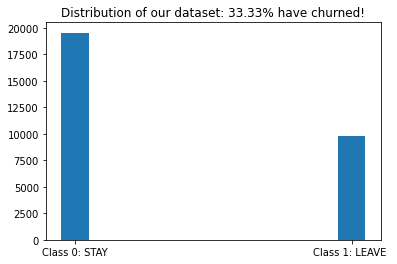

In [ ]:
data = {'Class 0: STAY': len(Y_aug[Y_aug==0]), 'Class 1: LEAVE ': len(Y_aug[Y_aug==1])}
names = list(data.keys())
values = list(data.values())

plt.bar(names,values,0.1)
plt.title('Distribution of our dataset: '+str(np.round(len(Y_aug[Y_aug==1])*100/(len(Y_aug[Y_aug==0])+len(Y_aug[Y_aug==1])),2))+'% have churned!')
plt.show()


In [ ]:
random_forest = RandomForestClassifier()

scoring = ['accuracy', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(random_forest, X_aug, Y_aug, verbose=1, scoring=scoring, cv=20)

sorted(scores.keys())
forest_fit_time = scores['fit_time'].mean()
forest_score_time = scores['score_time'].mean()
forest_accuracy = scores['test_accuracy'].mean()
forest_f1 = scores['test_f1_weighted'].mean()
forest_roc = scores['test_roc_auc'].mean()



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.7min finished


In [ ]:
xgb=XGBClassifier()
scoring = ['accuracy', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(xgb, X_aug, Y_aug,verbose=1, scoring=scoring, cv=StratifiedShuffleSplit(n_splits=10, random_state=42))

sorted(scores.keys())
XGB_fit_time = scores['fit_time'].mean()
XGB_score_time = scores['score_time'].mean()
XGB_accuracy = scores['test_accuracy'].mean()
XGB_f1 = scores['test_f1_weighted'].mean()
XGB_roc = scores['test_roc_auc'].mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   29.5s finished


In [ ]:
models_initial = pd.DataFrame({
    'Model'       : ['Random Forest',  'XGB'],
    'Fitting time': [ forest_fit_time,  XGB_fit_time],
    'Scoring time': [forest_score_time,  XGB_score_time],
    'Accuracy'    : [forest_accuracy,  XGB_accuracy],
    'F1_score'    : [ forest_f1,  XGB_f1],
    'AUC_ROC'     : [forest_roc,  XGB_roc],
    }, columns = ['Model', 'Fitting time', 'Scoring time', 'Accuracy', 'F1_score', 'AUC_ROC'])

models_initial.sort_values(by='AUC_ROC', ascending=True)


,Model,Fitting time,Scoring time,Accuracy,F1_score,AUC_ROC
1,XGB,2.903739,0.032581,0.886378,0.88194,0.950405
0,Random Forest,5.153481,0.083260,0.992116,0.99203,0.999549


#### Comment : 
We notice that the Data Augmentation improves the F1 Score and the ROC-AUC score of each model which makes it easier for models to detect churned clients. However, we could search for other data augmentation techniques which could be more efficient. 

## **VI. Metric Choice** 

In this classification problem, the goal is not only to fit a model with a good prediction accuracy, but also a model with a good separability between the classes. We are also more interested in the prediction of the positive class (Churn = Leave). To simplify, let denote $TP$ for True Positives, $TN$ for True Negatives, $FP$ for False Positives and $FN$ for False Negatives.  

We have the choice between 3 typical binary classification metrics : 
 
 
* Accuracy is, in our use case, the least significant metric which we will not be refering to. This is proved by the previous results and the accuracy score of the Dummy model, which only predicts 0. Here, the accuracy is even less useful due to the imbalance in our classification data and the majority of the class 0. The following analysis proves how the accuracy is not a representative metric. 

    \begin{equation}
    Accuracy=\frac{TP+TN}{TP+TN+FP+FN}
    \end{equation} 

* The F1-score combines precision and recall into one metric by calculating the harmonic mean between those two.  This score can be more significative when we care more about the positive class.

    \begin{equation}
    \begin{array}
    & F1_{Score}=2.\dfrac{Precision*Recall}{Precision+Recall} & where & Precision= \dfrac{TP}{TP+FP} \\
    & &  Recall=\dfrac{TP}{TP+TN}
    \end{array}
    \end{equation} 


 
* ROC AUC score means area under the curve of the ROC curve, which is a visualization of the tradeoff between true positive rate (TPR) and false positive rate (FPR). For every threshold, we calculate TPR and FPR and plot it. This score can tell us how capable is the model of distinguishing between the classes(Separability). Here we can see the ROC curve for the Random Forest classifier used above : 

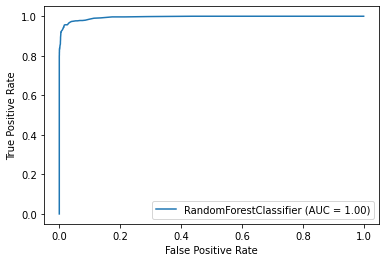

In [ ]:
rf_disp = plot_roc_curve(random_forest, X_test, y_test)
plt.show()

### **Assessing models: Confusion Matrix**

Another meaningful way to point out how the accuracy score is not representative of the robustness of a model in our case is to plot the Confusion Matrix. It will give a more generic matrix containing the proportion of True Negatives, True Positives, False Negatives and False Positives of our predictions.

We will use a basic split into Train and Test set as our objective here is to understand the confusion matrix results.

In [ ]:
# split in train test
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, random_state=0
)


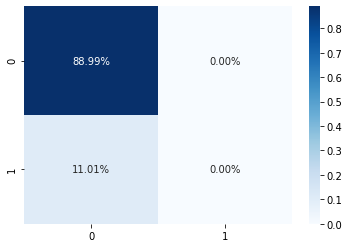

In [ ]:
dummy_pred = [0 for i in y_test]
cf_matrix =confusion_matrix(y_test, dummy_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')


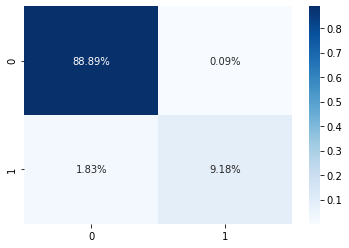

In [ ]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

rf_pred = random_forest.predict(X_test)

cf_matrix =confusion_matrix(y_test, rf_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')


Before discussing which metric to choose between the F1-score and the AUC score, observe that both are very robust evaluation metrics that work great for many classification problems. The main difference is that the F1-score uses predicted classes and the AUC uses predicted scores as input. Therefore, you need to choose a threshold for the F1-score in order to assign the observed data to the classes. For our use-case, both metrics can be used but we decided to use the AUC-ROC score as our classification metric, as we believe it that it might show a better reflexion of the "probability" distribution of our classes.

## **VII. To go further: Model Explanation**


Sometimes, one is not only interested in the output of a model but also in its explication. In fact, the more performing the model is, the more interesting it is to investigate how it computes its result. It is particularly relevant in a business case such as churning identification: it can allow a company to find what are the main factors that drive a customer to leave. In what follows, we propose some ways to explain the output of a model. We do so on the best Random Forest model we have developed in the previous part.

The first approach is to compute feature importance, i.e. a score that reflects how prevailing a feature is in the making of the final decision. The most common mechanism to compute feature importance of a Tree-based model is the mean decrease in impurity. It is computed by measuring how effective the feature is at reducing uncertainty when building the decision tree. 

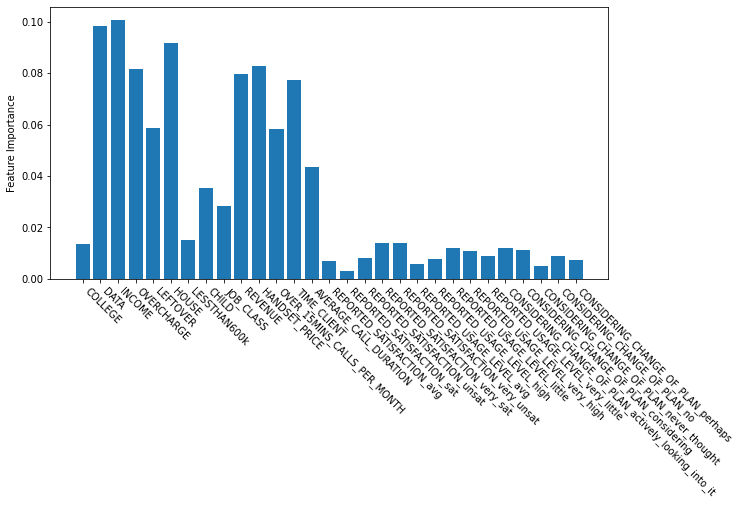

In [ ]:
best_clf = clf.best_estimator_

plt.figure(figsize=(10,5))
plt.bar(X_df.columns, best_clf.feature_importances_)
plt.xticks(X_df.columns, rotation=-45, ha='left')
plt.ylabel('Feature Importance')
plt.show()

We can see above that the Random Forest model identifies churning customers by relying mostly on the continuous variables (e.g. DATA, INCOME, HOUSE) and not that much on the categorical variables such as satisfaction or reported usage level.

The problem is that the default mechanism to compute this feature importance is biaised and does not give an accurate picture of importance. According to recent papers, it tends to inflate the importance of continuous or high-cardinality categorical variables.

### SHAP
An alternative is permutation importance which evaluates the effect of randomly permutating the values of a feature. However, this is a very computationally intensive operation. Another very popular alternative is SHAP (for SHapley Additive exPlanations) which uses the classic Shapley values from game theory and their related extensions. SHAP breaks down a prediction to show the impact of each feature. SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we would make if that feature took some baseline value.


In [ ]:
!pip install shap
import shap

In [ ]:
explainer = shap.TreeExplainer(best_clf)
X_sample = X_df[:1000] # keep only first 1000 lines so that it does not take too long to run
shap_values = explainer.shap_values(X_sample) 

SHAP is a local explainer, meaning that it finds for each observation the features that influenced the most the final decision. Those can be aggregated to compute global importance scores later.
Below we can see how each input feature contributes to the prediction that this client (randomly selected from the database) will stay (output 0) 

In [ ]:
sample_id = 42
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][sample_id,:], X_sample.iloc[sample_id,:])

We see that DATA and TIME_CLIENT are the most important factors to explain why this customer is staying.

This explanation can be applied to every observation in the data to produce the graph below. Since the model is very accurate in its predictions, we can clearly see the two parts corresponding to the two classes of the problem: staying (on the left) or leaving (on the right).

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1])

Another interesting property of SHAP values is that we can investigate each feature indepently. The partial dependence plot below shows the marginal effect that TIME_CLIENT has on the classification. It tells us that there is a relationship between TIME_CLIENT and churning probability but this relationship is complex (not linear nor monotonic). The customers with the smallest probability to leave (all other things being equal) are the ones which are neither recent of very old clients.

NB: the color scale corresponds to the feature that is most correlated with TIME_CLIENT (here DATA).
    

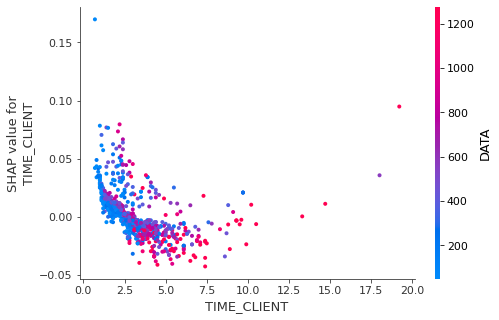

In [ ]:
TIME_CLIENT_ID = 12
shap.dependence_plot(TIME_CLIENT_ID, shap_values[1], X_sample)          

Finally, our objective was initially to recover a good feature importance score. The dotty plot below show how each feature impacts decision depending on its value. Features are ranked from the most important to the least important.
    

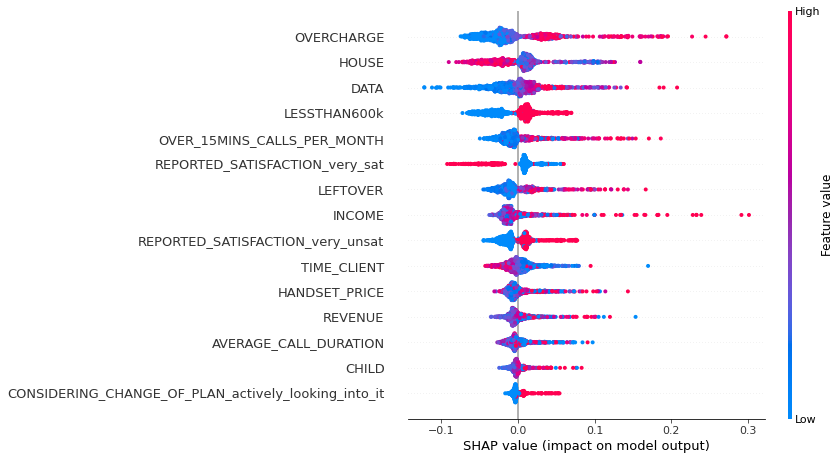

In [ ]:
shap.summary_plot(shap_values[1], X_sample, max_display=15, plot_type = "dot") # choosing plot_type = "bar" would give a plot more similar to sklearn's .feature_importances

SHAP conclusions are therefore different from default feature importance, and they are also finer. For instance, SHAP gives high importance to satisfaction level: if a customer declares itself "very satisfied" then it is a strong indication that he will not leave (and vice-versa for "very unsatisfied").

# **Conclusion**

We wanted to illustrate with this challenge how machine learning can help to tackle business problems such as customer churning. Through a rigorous inspection of the data, a business-oriented definition of the metrics to be optimized, a search for the best model and the best hyper-parameters, and finally with a draft explanation of the model, we believe we have laid the foundations for a solution that can be useful in the real world.
